In [9]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry

# Setup Open-Meteo API client with cache and retry
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Set daily weather variables
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 12.9716,
    "longitude": 77.5946,
    "start_date": "2015-09-16",
    "end_date": "2025-09-17",
    "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum", "rain_sum"],
    "timezone": "auto"
}

responses = openmeteo.weather_api(url, params=params)

# Process first location
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process daily data
daily = response.Daily()
daily_temperature_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_min = daily.Variables(1).ValuesAsNumpy()
daily_precipitation = daily.Variables(2).ValuesAsNumpy()
daily_rain = daily.Variables(3).ValuesAsNumpy()

# ✅ Build correct date range
dates = pd.date_range(
    start=pd.to_datetime(daily.Time(), unit="s", utc=True),
    end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=daily.Interval()),
    inclusive="left"
)

daily_data = {
    "Date": dates.tz_localize(None),  # drop UTC timezone
    "temperature_max": daily_temperature_max,
    "temperature_min": daily_temperature_min,
    "precipitation_sum": daily_precipitation,
    "rain_sum": daily_rain
}

daily_dataframe = pd.DataFrame(data=daily_data)

# Handle missing rain values → replace NaN with 0
daily_dataframe["rain_sum"] = daily_dataframe["rain_sum"].fillna(0)

daily_dataframe["Date"] = pd.to_datetime(daily_dataframe["Date"]).dt.date

print(daily_dataframe.head())
print(daily_dataframe.tail())


# Save CSV
daily_dataframe.to_csv("bangalore.csv", index=False)

Coordinates: 12.970123291015625°N 77.56363677978516°E
Elevation: 910.0 m asl
Timezone difference to GMT+0: 19800s
         Date  temperature_max  temperature_min  precipitation_sum  rain_sum
0  2015-09-15        25.786999        20.286999                2.6       2.6
1  2015-09-16        27.286999        19.837000                0.0       0.0
2  2015-09-17        26.937000        18.636999                0.0       0.0
3  2015-09-18        27.087000        19.737000                0.5       0.5
4  2015-09-19        26.587000        19.437000                2.1       2.1
            Date  temperature_max  temperature_min  precipitation_sum  \
3650  2025-09-12           28.011        18.811001                1.2   
3651  2025-09-13           27.761        18.761000                0.0   
3652  2025-09-14           28.361        19.061001                2.0   
3653  2025-09-15              NaN              NaN                NaN   
3654  2025-09-16              NaN              NaN         

In [3]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
from datetime import datetime, timedelta

# ----------------------------
# 🔹 Fetch data from Agmarknet
# ----------------------------
def fetch_agmarknet_data(commodity_code, state_code, district_id, market_id, date_from, date_to,
                         commodity_name="", state_name="", district_name="", market_name="--Select--"):
    url = "https://agmarknet.gov.in/SearchCmmMkt.aspx"
    params = {
        "Tx_Commodity": commodity_code,
        "Tx_State": state_code,
        "Tx_District": district_id,
        "Tx_Market": market_id,
        "DateFrom": date_from,
        "DateTo": date_to,
        "Fr_Date": date_from,
        "To_Date": date_to,
        "Tx_Trend": "0",
        "Tx_CommodityHead": commodity_name,
        "Tx_StateHead": state_name,
        "Tx_DistrictHead": district_name,
        "Tx_MarketHead": market_name,
        "ctl00$ddlArrivalPrice": "1" #arrival price
    }

    res = requests.get(url, params=params)
    res.raise_for_status()

    soup = BeautifulSoup(res.text, "html.parser")
    table = soup.find("table", {"id": "cphBody_GridPriceData"})
    
    if not table:
        return {"error": "No data table found. Check your parameters."}

    data = []
    headers = [th.get_text(strip=True) for th in table.find_all("th")]

    for row in table.find_all("tr")[1:]:  # skip header
        cols = [c.get_text(strip=True) for c in row.find_all("td")]
        if cols:
            data.append(dict(zip(headers, cols)))

    return data

# ----------------------------
# 🔹 Date range (last 3 years, ending 10 days ago)
# ----------------------------
end_date = datetime.now().date()
start_date = end_date - timedelta(days=10*365)

date_from = start_date.strftime("%d-%b-%Y")
date_to = end_date.strftime("%d-%b-%Y")

print(f"Fetching data from {date_from} to {date_to}...")

data = fetch_agmarknet_data(
    commodity_code="78",      # Example: Apple
    state_code="KK",          # Karnataka
    district_id="1",          # Bangalore
    market_id="108",          # Binny Mill (F&V)
    date_from=date_from,
    date_to=date_to,
    commodity_name="Tomato",
    state_name="Karnataka",
    district_name="Bangalore"
)

# ----------------------------
# 🔹 Save & clean the dataset
# ----------------------------
if isinstance(data, list) and data:
    filename = "agmarknet_data_new1.csv"
    with open(filename, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)
    print(f"✅ Data saved to {filename}")

    # Load data into pandas
    commodity_df = pd.read_csv(filename)

    # Rename columns
    commodity_df.rename(columns={
        "Price Date": "Date",
        "Min Price (Rs./Quintal)": "Min_Price",
        "Max Price (Rs./Quintal)": "Max_Price",
        "Modal Price (Rs./Quintal)": "Modal_Price"
    }, inplace=True)

    # Convert Date to datetime
    commodity_df["Date"] = pd.to_datetime(commodity_df["Date"], format="%d %b %Y", errors="coerce")

    # Keep clean date format
    commodity_df["date"] = commodity_df["Date"].dt.date

    # ----------------------------
    # 🔹 Encode Grade dynamically
    # ----------------------------
    unique_grades = commodity_df["Grade"].unique()
    grade_mapping = {grade: idx for idx, grade in enumerate(unique_grades)}
    commodity_df["Grade_num"] = commodity_df["Grade"].map(grade_mapping)

    print("Dynamic grade mapping:", grade_mapping)

    # ----------------------------
    # 🔹 Encode Variety dynamically
    # ----------------------------
    unique_varieties = commodity_df["Variety"].unique()
    variety_mapping = {var: idx for idx, var in enumerate(unique_varieties)}
    commodity_df["Variety_num"] = commodity_df["Variety"].map(variety_mapping)

    print("Dynamic variety mapping:", variety_mapping)

    # ----------------------------
    # 🔹 Final dataset
    # ----------------------------
    commodity_df.to_csv("Tomato.csv", index=False)
    print("✅ Cleaned dataset saved to cleaned_agmarknet_data.csv")

    print(commodity_df.head())

else:
    print("❌ No data found:", data)

Fetching data from 20-Sep-2015 to 17-Sep-2025...
✅ Data saved to agmarknet_data_new1.csv
Dynamic grade mapping: {'FAQ': 0, 'Local': 1, 'Ref grade-2': 2, 'Ref grade-1': 3}
Dynamic variety mapping: {'Tomato': 0}
✅ Cleaned dataset saved to cleaned_agmarknet_data.csv
   Sl no. District Name                  Market Name Commodity Variety Grade  \
0       1     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   FAQ   
1       2     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   FAQ   
2       3     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   FAQ   
3       4     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   FAQ   
4       5     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   FAQ   

   Min_Price  Max_Price  Modal_Price       Date        date  Grade_num  \
0        500        700          600 2018-02-21  2018-02-21          0   
1       1100       1300         1200 2021-10-01  2021-10-01          0   
2       3000       3500         3

In [13]:
import pandas as pd
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Read data
commodity_df = pd.read_csv("Tomato.csv")
weather_df = pd.read_csv("bangalore.csv")

# Convert both date columns to datetime format
commodity_df['Date'] = pd.to_datetime(commodity_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

# Merge on Date
merged_df = pd.merge(
    commodity_df,
    weather_df,
    on="Date",   # common column
    how="left"   # keep all commodity rows, add weather if date matches
)

# Check result
merged_df.to_csv("Tomato_bangalore.csv", index=False)

# Save to new CSV (optional)




# Load your existing merged data
merged_df = pd.read_csv("Tomato_bangalore.csv")
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df = merged_df.sort_values("Date").reset_index(drop=True)
unique_markets = merged_df["Market Name"].unique()
print("Unique Market Names:", unique_markets)

# Create mapping {market_name: id}
market_mapping = {name: idx for idx, name in enumerate(unique_markets, start=1)}
print("\nMapping:", market_mapping)

# Map to integer column
merged_df["Market_ID"] = merged_df["Market Name"].map(market_mapping)


print("Data shape:", merged_df.shape)
print("\nColumns:", merged_df.columns.tolist())
print("\nFirst few rows:")
print(merged_df.tail(5))

Unique Market Names: ['Binny Mill (F&V), Bangalore']

Mapping: {'Binny Mill (F&V), Bangalore': 1}
Data shape: (2509, 18)

Columns: ['Sl no.', 'District Name', 'Market Name', 'Commodity', 'Variety', 'Grade', 'Min_Price', 'Max_Price', 'Modal_Price', 'Date', 'date', 'Grade_num', 'Variety_num', 'temperature_max', 'temperature_min', 'precipitation_sum', 'rain_sum', 'Market_ID']

First few rows:
      Sl no. District Name                  Market Name Commodity Variety  \
2504    2328     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   
2505    1745     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   
2506    1450     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   
2507    1856     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   
2508    1851     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   

      Grade  Min_Price  Max_Price  Modal_Price       Date        date  \
2504  Local       1000       1200         1100 2025-09-11  2025-09-11  

In [14]:
merged_df

,Sl no.,District Name,Market Name,Commodity,Variety,Grade,Min_Price,Max_Price,Modal_Price,Date,date,Grade_num,Variety_num,temperature_max,temperature_min,precipitation_sum,rain_sum,Market_ID
0,2476,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,FAQ,600,900,700,2015-09-21,2015-09-21,0,0,28.387000,17.437,0.000000,0.000000,1
1,1367,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,FAQ,700,900,800,2015-09-22,2015-09-22,0,0,28.337000,17.837,0.000000,0.000000,1
2,648,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,FAQ,800,1200,1000,2015-09-23,2015-09-23,0,0,28.937000,20.387,13.300000,13.300000,1
3,2352,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,FAQ,1000,1400,1200,2015-09-24,2015-09-24,0,0,28.237000,18.987,15.599999,15.599999,1
4,336,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,FAQ,1200,1800,1600,2015-09-28,2015-09-28,0,0,26.587000,18.737,1.300000,1.300000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2504,2328,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,Local,1000,1200,1100,2025-09-11,2025-09-11,1,0,27.161001,19.561,0.400000,0.400000,1
2505,1745,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,Local,1000,1200,1100,2025-09-12,2025-09-12,1,0,28.011000,18.811,1.200000,1.200000,1
2506,1450,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,Local,1000,1200,1100,2025-09-15,2025-09-15,1,0,28.361000,19.061,2.000000,2.000000,1
2507,1856,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,Local,1000,1200,1100,2025-09-16,2025-09-16,1,0,28.361000,19.061,2.000000,2.000000,1


In [15]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load your existing merged data
merged_df = pd.read_csv("Tomato_bangalore.csv")
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df = merged_df.sort_values("Date").reset_index(drop=True)
unique_markets = merged_df["Market Name"].unique()
print("Unique Market Names:", unique_markets)

# Create mapping {market_name: id}
market_mapping = {name: idx for idx, name in enumerate(unique_markets, start=1)}
print("\nMapping:", market_mapping)

# Map to integer column
merged_df["Market_ID"] = merged_df["Market Name"].map(market_mapping)


print("Data shape:", merged_df.shape)
print("\nColumns:", merged_df.columns.tolist())
print("\nFirst few rows:")
print(merged_df.tail(5))

Unique Market Names: ['Binny Mill (F&V), Bangalore']

Mapping: {'Binny Mill (F&V), Bangalore': 1}
Data shape: (2509, 18)

Columns: ['Sl no.', 'District Name', 'Market Name', 'Commodity', 'Variety', 'Grade', 'Min_Price', 'Max_Price', 'Modal_Price', 'Date', 'date', 'Grade_num', 'Variety_num', 'temperature_max', 'temperature_min', 'precipitation_sum', 'rain_sum', 'Market_ID']

First few rows:
      Sl no. District Name                  Market Name Commodity Variety  \
2504    2328     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   
2505    1745     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   
2506    1450     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   
2507    1856     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   
2508    1851     Bangalore  Binny Mill (F&V), Bangalore    Tomato  Tomato   

      Grade  Min_Price  Max_Price  Modal_Price       Date        date  \
2504  Local       1000       1200         1100 2025-09-11  2025-09-11  

In [16]:
# Step 2: Feature Engineering for XGBoost
def create_time_features(df):
    """Create time-based features from date column"""
    df = df.copy()
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['quarter'] = df['Date'].dt.quarter
    return df

# Create time features
df = create_time_features(merged_df)

# Create lag features (same as before)
df["lag_1"] = df["Modal_Price"].shift(1)
df["lag_7"] = df["Modal_Price"].shift(7)
df["lag_14"] = df["Modal_Price"].shift(14)  # Additional lag feature

# Create rolling features
df["rolling_mean_7"] = df["Modal_Price"].shift(1).rolling(7).mean()
df["rolling_std_7"] = df["Modal_Price"].shift(1).rolling(7).std()
df["rolling_mean_14"] = df["Modal_Price"].shift(1).rolling(14).mean()

# Create price change features
df["price_change_1d"] = df["Modal_Price"].pct_change(1)
df["price_change_7d"] = df["Modal_Price"].pct_change(7)

print("Features created successfully!")
print("New shape:", df.shape)
df.tail()

Features created successfully!
New shape: (2509, 32)


,Sl no.,District Name,Market Name,Commodity,Variety,Grade,Min_Price,Max_Price,Modal_Price,Date,...,dayofyear,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7,rolling_mean_14,price_change_1d,price_change_7d
2504,2328,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,Local,1000,1200,1100,2025-09-11,...,254,3,1100.0,2400.0,3400.0,1842.857143,694.879229,2671.428571,0.0,-0.541667
2505,1745,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,Local,1000,1200,1100,2025-09-12,...,255,3,1100.0,2400.0,3400.0,1657.142857,694.879229,2507.142857,0.0,-0.541667
2506,1450,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,Local,1000,1200,1100,2025-09-15,...,258,3,1100.0,2400.0,3800.0,1471.428571,634.335047,2342.857143,0.0,-0.541667
2507,1856,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,Local,1000,1200,1100,2025-09-16,...,259,3,1100.0,2400.0,3800.0,1285.714286,491.353815,2150.000000,0.0,-0.541667
2508,1851,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Tomato,Local,1000,1200,1100,2025-09-17,...,260,3,1100.0,1100.0,3800.0,1100.000000,0.000000,1957.142857,0.0,0.000000


In [18]:
# Step 3: Define features for XGBoost
feature_columns = [
    # Weather features
    'temperature_max', 'temperature_min', 'rain_sum',
    
    # Lag features
    'lag_1', 'lag_7', 'lag_14',
    
    # Rolling features
    'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14',
    
    # Time features
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter',
    
    # Grade and Variety (if they exist)
    'Grade_num', 'Variety_num',
    
    # Price change features
    'price_change_1d', 'price_change_7d'
]

# Check which features actually exist in your dataframe
existing_features = [col for col in feature_columns if col in df.columns]
missing_features = [col for col in feature_columns if col not in df.columns]

print("Existing features:", existing_features)
print("Missing features:", missing_features)

# Use only existing features
features = existing_features
target = 'Modal_Price'

print(f"\nUsing {len(features)} features for modeling")
print("Target variable:", target)



Existing features: ['temperature_max', 'temperature_min', 'rain_sum', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter', 'Grade_num', 'Variety_num', 'price_change_1d', 'price_change_7d']
Missing features: []

Using 19 features for modeling
Target variable: Modal_Price


In [19]:
# Step 4: Clean data and create train-test split
# Remove rows with NaN values
df_clean = df.dropna(subset=features + [target]).reset_index(drop=True)

print(f"Data shape after cleaning: {df_clean.shape}")
print(f"Rows dropped due to NaN: {len(df) - len(df_clean)}")

# Create features and target arrays
X = df_clean[features]
y = df_clean[target]

# Same split as Prophet (last 30 days for testing)
test_days = 500
train_size = len(df_clean) - test_days

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"\nTrain size: {len(X_train)}")
print(f"Test size: {len(X_test)}")
print(f"Feature dimensions: {X_train.shape[1]}")

# Display feature importance overview
print(f"\nFeatures being used:")
for i, feature in enumerate(features):
    print(f"{i+1:2d}. {feature}")

Data shape after cleaning: (2494, 32)
Rows dropped due to NaN: 15

Train size: 1994
Test size: 500
Feature dimensions: 19

Features being used:
 1. temperature_max
 2. temperature_min
 3. rain_sum
 4. lag_1
 5. lag_7
 6. lag_14
 7. rolling_mean_7
 8. rolling_std_7
 9. rolling_mean_14
10. year
11. month
12. day
13. dayofweek
14. dayofyear
15. quarter
16. Grade_num
17. Variety_num
18. price_change_1d
19. price_change_7d


In [20]:
# Step 5: Train basic XGBoost model
# Create XGBoost regressor with initial parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit the model
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== XGBoost Results ===")
print(f"Train MAE: {train_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")

print("\nModel trained successfully! ✅")

Training XGBoost model...

=== XGBoost Results ===
Train MAE: 16.47
Train RMSE: 22.91
Test MAE: 58.23
Test RMSE: 146.37
Test MAPE: 2.31%

Model trained successfully! ✅


In [21]:
from sklearn.metrics import r2_score
score = r2_score(y_test, y_pred_test)
print(round(score,2)*100)

98.0


Top 10 Most Important Features:
            feature  importance
3             lag_1    0.606943
6    rolling_mean_7    0.286287
18  price_change_7d    0.031067
17  price_change_1d    0.028750
9              year    0.027819
4             lag_7    0.004359
11              day    0.003225
8   rolling_mean_14    0.003102
0   temperature_max    0.002951
1   temperature_min    0.001384


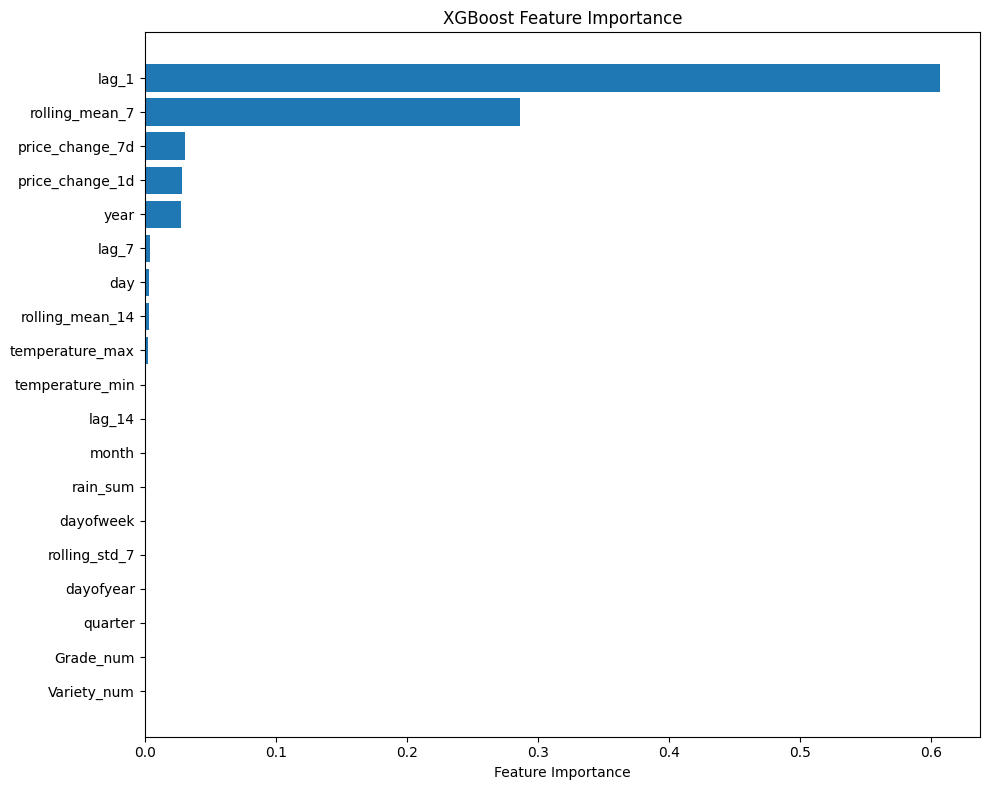


Top 5 features: ['lag_1', 'rolling_mean_7', 'price_change_7d', 'price_change_1d', 'year']


In [22]:
# Step 6: Analyze feature importance
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Show which features contribute most
top_5_features = importance_df.head(5)['feature'].tolist()
print(f"\nTop 5 features: {top_5_features}")

In [23]:
# Step 7: Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define parameter grid (keeping it simple to avoid long runtime)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Create XGBoost model for grid search
xgb_grid = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.8
)

# Perform grid search with 3-fold CV
print("Starting hyperparameter tuning...")
print("This might take a few minutes...")

grid_search = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert back to positive MAE

print(f"\nBest parameters: {best_params}")
print(f"Best CV MAE: {best_score:.2f}")

# Train best model
best_xgb_model = grid_search.best_estimator_

Starting hyperparameter tuning...
This might take a few minutes...
Fitting 3 folds for each of 81 candidates, totalling 243 fits



Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.9}
Best CV MAE: 134.26


In [24]:
# Step 8: Evaluate best model
# Make predictions with best model
y_pred_best_train = best_xgb_model.predict(X_train)
y_pred_best_test = best_xgb_model.predict(X_test)

# Calculate metrics for best model
best_train_mae = mean_absolute_error(y_train, y_pred_best_train)
best_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_best_train))

best_test_mae = mean_absolute_error(y_test, y_pred_best_test)
best_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_test))
best_test_mape = np.mean(np.abs((y_test - y_pred_best_test) / y_test)) * 100

print("\n=== FINAL RESULTS COMPARISON ===")
print("\n📊 Basic XGBoost:")
print(f"   Test MAE: {test_mae:.2f}")
print(f"   Test RMSE: {test_rmse:.2f}")
print(f"   Test MAPE: {test_mape:.2f}%")

print("\n🎯 Tuned XGBoost:")
print(f"   Test MAE: {best_test_mae:.2f}")
print(f"   Test RMSE: {best_test_rmse:.2f}")
print(f"   Test MAPE: {best_test_mape:.2f}%")

# Calculate improvement
mae_improvement = ((test_mae - best_test_mae) / test_mae) * 100
print(f"\n📈 Improvement: {mae_improvement:.1f}% better MAE")

# Print best parameters for reference
print(f"\n🔧 Best Parameters:")
for param, value in best_params.items():
    print(f"   {param}: {value}")


=== FINAL RESULTS COMPARISON ===

📊 Basic XGBoost:
   Test MAE: 58.23
   Test RMSE: 146.37
   Test MAPE: 2.31%

🎯 Tuned XGBoost:
   Test MAE: 47.90
   Test RMSE: 126.42
   Test MAPE: 1.98%

📈 Improvement: 17.7% better MAE

🔧 Best Parameters:
   learning_rate: 0.1
   max_depth: 4
   n_estimators: 300
   subsample: 0.9


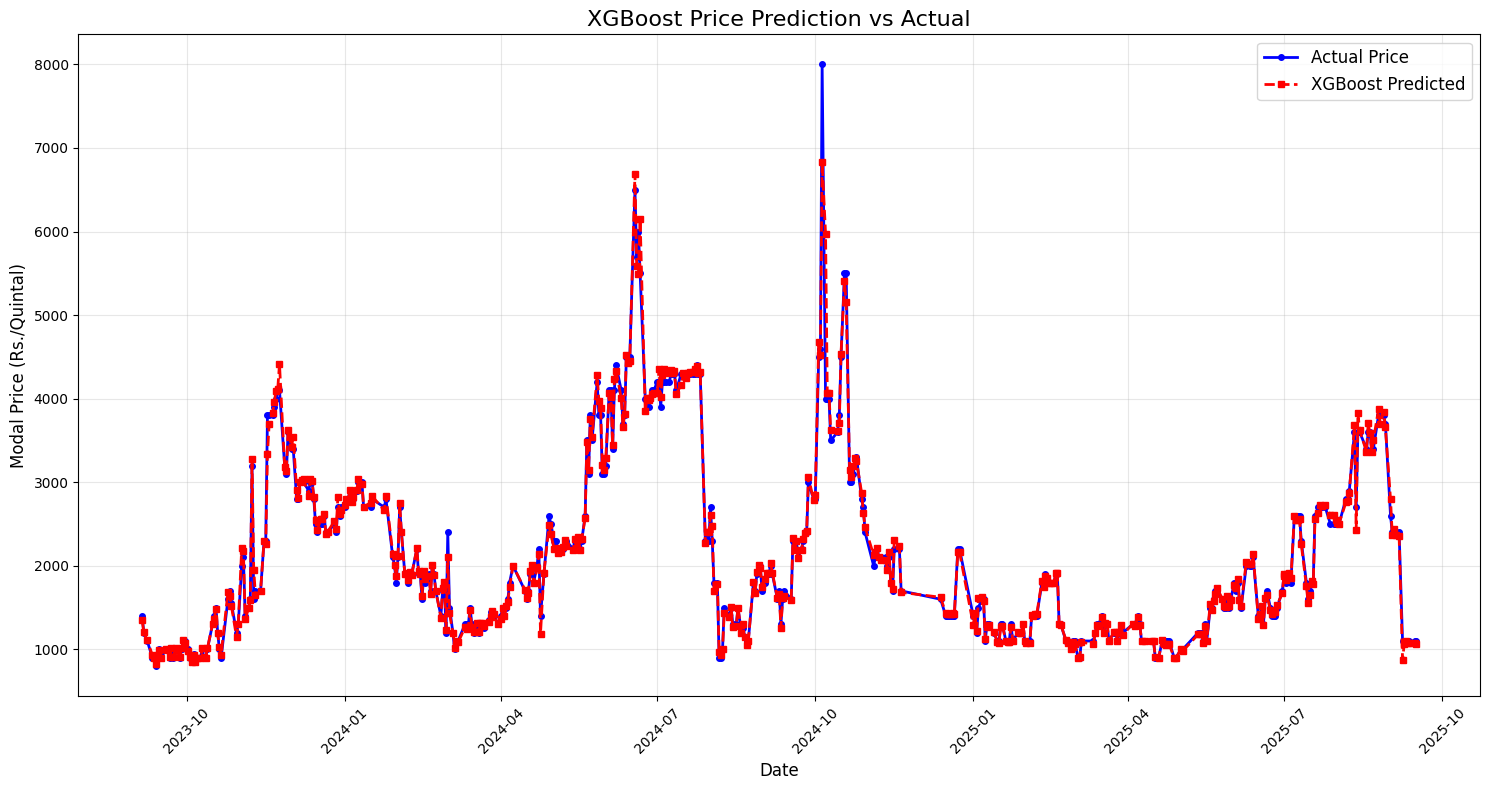

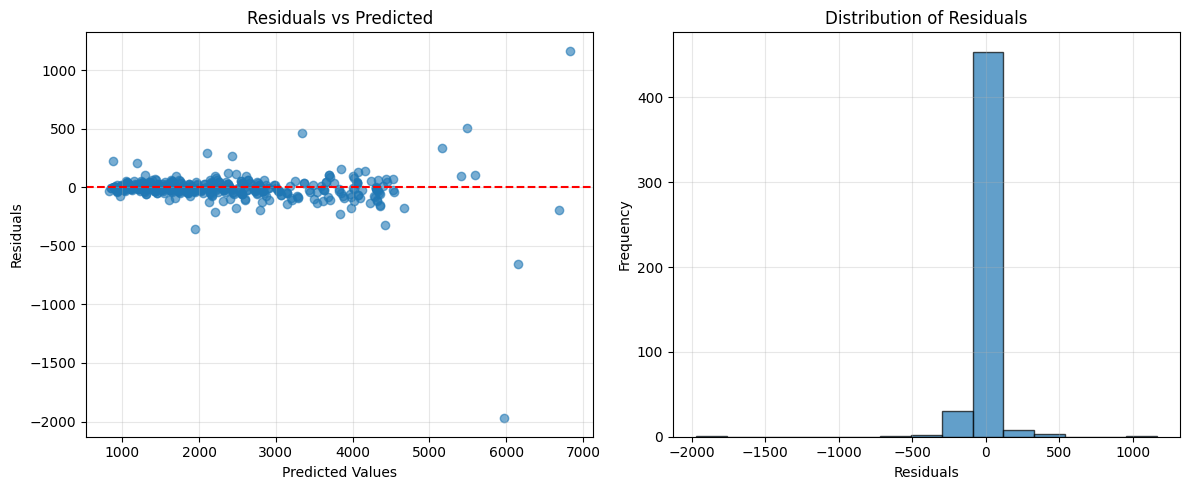

📊 Visualization completed!
Mean residual: -6.45
Std residual: 126.25


In [25]:
# Step 9: Visualize predictions
import matplotlib.pyplot as plt

# Get dates for test period
test_dates = df_clean['Date'].iloc[train_size:].values

# Create visualization
plt.figure(figsize=(15, 8))

# Plot actual vs predicted
plt.plot(test_dates, y_test.values, 'b-', label='Actual Price', linewidth=2, marker='o', markersize=4)
plt.plot(test_dates, y_pred_best_test, 'r--', label='XGBoost Predicted', linewidth=2, marker='s', markersize=4)

plt.title('XGBoost Price Prediction vs Actual', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Modal Price (Rs./Quintal)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate residuals
residuals = y_test.values - y_pred_best_test

# Plot residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_best_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Visualization completed!")
print(f"Mean residual: {np.mean(residuals):.2f}")
print(f"Std residual: {np.std(residuals):.2f}")

In [26]:
# Step 10: Make future predictions (if you have future weather data)
# This is similar to your Prophet approach but adapted for XGBoost

def create_future_features(last_known_price, last_known_features, future_weather, n_days=7):
    """
    Create features for future prediction
    """
    future_features = []
    current_price = last_known_price
    
    for i in range(n_days):
        # Get weather for this day
        weather_row = future_weather.iloc[i]
        
        # Create feature row
        feature_row = {}
        
        # Weather features
        if 'temperature_max' in features:
            feature_row['temperature_max'] = weather_row['temperature_max']
        if 'temperature_min' in features:
            feature_row['temperature_min'] = weather_row['temperature_min']
        if 'rain_sum' in features:
            feature_row['rain_sum'] = weather_row['rain_sum']
        
        # Time features (you'll need to calculate based on the future date)
        future_date = weather_row['ds'] if 'ds' in weather_row else pd.Timestamp.now() + pd.Timedelta(days=i)
        if 'year' in features:
            feature_row['year'] = future_date.year
        if 'month' in features:
            feature_row['month'] = future_date.month
        if 'day' in features:
            feature_row['day'] = future_date.day
        if 'dayofweek' in features:
            feature_row['dayofweek'] = future_date.dayofweek
        if 'dayofyear' in features:
            feature_row['dayofyear'] = future_date.dayofyear
        if 'quarter' in features:
            feature_row['quarter'] = future_date.quarter
        
        # Lag features (use last known or predicted values)
        if 'lag_1' in features:
            feature_row['lag_1'] = current_price
        if 'lag_7' in features:
            feature_row['lag_7'] = last_known_features['lag_7'] if i == 0 else current_price
        if 'lag_14' in features:
            feature_row['lag_14'] = last_known_features['lag_14']
        
        # Rolling features (simplified - use last known values)
        if 'rolling_mean_7' in features:
            feature_row['rolling_mean_7'] = last_known_features['rolling_mean_7']
        if 'rolling_std_7' in features:
            feature_row['rolling_std_7'] = last_known_features['rolling_std_7']
        if 'rolling_mean_14' in features:
            feature_row['rolling_mean_14'] = last_known_features['rolling_mean_14']
        
        # Grade and variety (use last known)
        if 'Grade_num' in features:
            feature_row['Grade_num'] = last_known_features['Grade_num']
        if 'Variety_num' in features:
            feature_row['Variety_num'] = last_known_features['Variety_num']
        
        # Price change features (set to 0 for simplicity)
        if 'price_change_1d' in features:
            feature_row['price_change_1d'] = 0.0
        if 'price_change_7d' in features:
            feature_row['price_change_7d'] = 0.0
        
        future_features.append(feature_row)
        
        # Update current_price for next iteration (predict and use)
        if i < n_days - 1:  # Don't predict on last iteration
            feature_df = pd.DataFrame([feature_row])
            feature_df = feature_df.reindex(columns=features, fill_value=0)
            current_price = best_xgb_model.predict(feature_df)[0]
    
    return pd.DataFrame(future_features)

# print("Future prediction function created!")
# print("\nTo use this for future predictions:")
# print("1. Get your future weather data")
# print("2. Call: future_df = create_future_features(last_price, last_features, weather_future)")
# print("3. Make predictions: future_preds = best_xgb_model.predict(future_df)")
print("\n✅ XGBoost implementation complete!")


✅ XGBoost implementation complete!


In [27]:
# XGBoost 7-Day Price Prediction

# Step 1: Get the last known values from your training data
last_row_index = len(df_clean) - 1
last_known_price = df_clean[target].iloc[last_row_index]
last_known_date = df_clean['Date'].iloc[last_row_index]

# Get last known feature values
last_known_features = {}
for feature in features:
    last_known_features[feature] = df_clean[feature].iloc[last_row_index]

print(f"Last known price: ₹{last_known_price:.2f}")
print(f"Last known date: {last_known_date}")
print(f"Using {len(features)} features for prediction")

# Step 2: Create future weather data (you can modify this with real future weather data)
# For now, I'll create sample future weather based on recent averages
recent_weather = df_clean[['temperature_max', 'temperature_min', 'rain_sum']].tail(7).mean()

future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=7, freq='D')
future_weather = pd.DataFrame({
    'ds': future_dates,
    'temperature_max': [recent_weather['temperature_max']] * 7,
    'temperature_min': [recent_weather['temperature_min']] * 7, 
    'rain_sum': [recent_weather['rain_sum']] * 7
})

print(f"\nFuture weather forecast:")
print(future_weather)

Last known price: ₹1100.00
Last known date: 2025-09-16 00:00:00
Using 19 features for prediction

Future weather forecast:
          ds  temperature_max  temperature_min  rain_sum
0 2025-09-17        27.675286           19.161  2.328571
1 2025-09-18        27.675286           19.161  2.328571
2 2025-09-19        27.675286           19.161  2.328571
3 2025-09-20        27.675286           19.161  2.328571
4 2025-09-21        27.675286           19.161  2.328571
5 2025-09-22        27.675286           19.161  2.328571
6 2025-09-23        27.675286           19.161  2.328571


In [28]:
# Step 3: Create future features and make predictions
def make_7day_predictions(model, last_price, last_features, future_weather, features_list):
    """
    Make 7-day predictions using XGBoost
    """
    predictions = []
    current_price = last_price
    
    for i in range(7):
        # Get weather for this day
        weather_row = future_weather.iloc[i]
        future_date = weather_row['ds']
        
        # Create feature row
        feature_row = {}
        
        # Weather features
        if 'temperature_max' in features_list:
            feature_row['temperature_max'] = weather_row['temperature_max']
        if 'temperature_min' in features_list:
            feature_row['temperature_min'] = weather_row['temperature_min']
        if 'rain_sum' in features_list:
            feature_row['rain_sum'] = weather_row['rain_sum']
        
        # Time features
        if 'year' in features_list:
            feature_row['year'] = future_date.year
        if 'month' in features_list:
            feature_row['month'] = future_date.month
        if 'day' in features_list:
            feature_row['day'] = future_date.day
        if 'dayofweek' in features_list:
            feature_row['dayofweek'] = future_date.dayofweek
        if 'dayofyear' in features_list:
            feature_row['dayofyear'] = future_date.dayofyear
        if 'quarter' in features_list:
            feature_row['quarter'] = future_date.quarter
        
        # Lag features - use current_price as lag_1 for next prediction
        if 'lag_1' in features_list:
            feature_row['lag_1'] = current_price
        if 'lag_7' in features_list:
            if i == 0:
                feature_row['lag_7'] = last_features.get('lag_7', current_price)
            else:
                # Use price from 7 days ago if available, otherwise current
                feature_row['lag_7'] = predictions[0] if i >= 1 else current_price
        if 'lag_14' in features_list:
            feature_row['lag_14'] = last_features.get('lag_14', current_price)
        
        # Rolling features (use last known values - in real scenario, you'd update these)
        if 'rolling_mean_7' in features_list:
            feature_row['rolling_mean_7'] = last_features.get('rolling_mean_7', current_price)
        if 'rolling_std_7' in features_list:
            feature_row['rolling_std_7'] = last_features.get('rolling_std_7', 0)
        if 'rolling_mean_14' in features_list:
            feature_row['rolling_mean_14'] = last_features.get('rolling_mean_14', current_price)
        
        # Categorical features
        if 'Grade_num' in features_list:
            feature_row['Grade_num'] = last_features.get('Grade_num', 0)
        if 'Variety_num' in features_list:
            feature_row['Variety_num'] = last_features.get('Variety_num', 0)
        
        # Price change features (set to small values)
        if 'price_change_1d' in features_list:
            feature_row['price_change_1d'] = 0.01  # 1% change assumption
        if 'price_change_7d' in features_list:
            feature_row['price_change_7d'] = 0.02  # 2% change assumption
        
        # Create DataFrame with correct feature order
        feature_df = pd.DataFrame([feature_row])
        feature_df = feature_df.reindex(columns=features_list, fill_value=0)
        
        # Make prediction
        prediction = model.predict(feature_df)[0]
        predictions.append(prediction)
        
        # Update current_price for next iteration
        current_price = prediction
        
        print(f"Day {i+1} ({future_date.strftime('%Y-%m-%d')}): ₹{prediction:.2f}")
    
    return predictions, future_dates

# Make the predictions
print("🔮 Making 7-day predictions with XGBoost:")
print("=" * 50)


print(f"Last known price: ₹{last_known_price:.2f}")
print(f"Last known date: {last_known_date}")

predictions_7day, prediction_dates = make_7day_predictions(
    best_xgb_model, 
    last_known_price, 
    last_known_features, 
    future_weather, 
    features
)

🔮 Making 7-day predictions with XGBoost:
Last known price: ₹1100.00
Last known date: 2025-09-16 00:00:00
Day 1 (2025-09-17): ₹1098.65
Day 2 (2025-09-18): ₹1011.48
Day 3 (2025-09-19): ₹1011.48
Day 4 (2025-09-20): ₹1011.48
Day 5 (2025-09-21): ₹1011.38
Day 6 (2025-09-22): ₹1005.70
Day 7 (2025-09-23): ₹1005.70


In [44]:
df_clean.tail(5)

,State Name,District Name,Market Name,Variety,Group,Arrivals (Tonnes),Min_Price,Max_Price,Modal_Price,Date,...,dayofyear,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7,rolling_mean_14,price_change_1d,price_change_7d
2484,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Fruits,77.00,10000,14000,12000,2025-09-09,...,252,3,12000.0,14000.0,12000.0,12571.428571,975.900073,12500.0,0.000000,-0.142857
2485,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Fruits,133.00,10000,16000,12000,2025-09-10,...,253,3,12000.0,12000.0,12000.0,12285.714286,755.928946,12500.0,0.000000,0.000000
2486,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Fruits,190.00,10000,16000,12000,2025-09-12,...,255,3,12000.0,12000.0,12000.0,12285.714286,755.928946,12500.0,0.000000,0.000000
2487,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Fruits,378.00,10000,16000,12000,2025-09-15,...,258,3,12000.0,12000.0,12000.0,12285.714286,755.928946,12500.0,0.000000,0.000000
2488,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Fruits,337.00,10000,16000,13000,2025-09-16,...,259,3,12000.0,14000.0,12000.0,12285.714286,755.928946,12500.0,0.083333,-0.071429
